### Model Validity & Evaluation

The purpose of this sheet is to evaluate the best model that was generated in the previous sheets to determine if/where each model is inefficient and to verify the validity of the models.

### Library Imports

In [1]:
import numpy as np
from numpy.linalg import inv

import pandas as pd
import matplotlib.pyplot as plt
import requests
import pickle
import time
import seaborn as sns
from PIL import Image

import plotly.express as px
import plotly.offline as pyo
import plotly.io as pio
import plotly.graph_objects as go
pio.renderers.default = 'notebook'

import dash
from dash import Dash, dcc, html, Input, Output
from dash import dcc
import dash_html_components as html
from dash.dependencies import Input, Output

import pycaret
from pycaret.regression import *
from pycaret.regression import RegressionExperiment
from pycaret.regression import get_config
from pycaret.regression import save_model, load_model

from pandas import json_normalize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error,r2_score,mean_absolute_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.metrics import mean_squared_error

/var/folders/fm/_6kg8xkn3jz4slz27zwpqnhc0000gn/T/ipykernel_60751/281355502.py:21: UserWarning:


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`



In [2]:
pd.set_option('display.max_columns', None)

### Data Imports

In [3]:
with open('pickles/df_user.pkl', 'rb') as f:
    df_user = pickle.load(f)
with open('pickles/df_adj.pkl', 'rb') as f:
    df_adj = pickle.load(f)
with open('pickles/data_user.pkl', 'rb') as f:
    data_user = pickle.load(f)
with open('pickles/data_user_unseen.pkl', 'rb') as f:
    data_user_unseen = pickle.load(f)
with open('pickles/predictions_user.pkl', 'rb') as f:
    predictions_user = pickle.load(f)

### User Friendly Model Evaluation

Within this subsection, I'll evaluate the model created in the previous sheet that used categorical features in place of the original continuous features. This model is intended to be more interpretable for the end user.

#### Data & Model Setup

In [4]:
data = data_user
data_unseen = data_user_unseen
predictions = predictions_user

In [5]:
data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

In [6]:
data.shape

(1046, 23)

In [7]:
user_model = load_model('models/blended_user_tuned')

Transformation Pipeline and Model Successfully Loaded


### Residuals

From the user model predictions generated on the last sheet, we'll use the predictions to prove the validity of the model.

In [8]:
predictions['Residuals'] = predictions['cost_real_2023'] - predictions['prediction_label']

In [9]:
mean_res = np.mean(predictions['Residuals'])
std_res = np.std(predictions['Residuals'])
predictions['standardized_residuals'] = (predictions['Residuals'] - mean_res) / std_res

In [10]:
predictions.head(3)

,length,tunnel,elevated,at_grade,stations,anglo?,train_type,duration,region,sub_region,soil_type,gauge_width,city_size,country_income_class,elevation_class,precipitation_type,temperature_category,affordability,union_prevalence,poverty_rate,city_density_type,country_density_type,cost_real_2023,prediction_label,Residuals,standardized_residuals
0,14.94,1.30,13.64,0.0,11.0,no,MRT,4.0,Asia,Eastern Asia,River Valleys/Deltas (River Sediments),standard,2M-5M (large),lower-middle income,Coastal,High,Mild/Moderate,Unaffordable,Many Labor Unions,Very Impoverished,Dense,Dense,1403.682251,1999.226236,-595.543985,-0.854856
1,6.54,6.04,0.50,0.0,5.0,no,MRT,5.0,Asia,Eastern Asia,River Valleys/Deltas (River Sediments),standard,5M-10M (very large),low-income,Coastal,High,Mild/Moderate,Unaffordable,Many Labor Unions,Very Impoverished,Very Dense,Dense,2003.338623,1329.519088,673.819535,1.030264
2,1.50,0.00,0.00,1.5,2.0,no,Tram,3.0,Europe,Southern Europe,Clay Dominant,standard,2M-5M (large),upper-middle income,Coastal,Moderate,Mild/Moderate,Unaffordable,Most People are Part of a Labor Union,Little Poverty,Dense,Very Dense,37.010651,65.961115,-28.950464,-0.013413


In [11]:
fig = px.scatter(predictions,color = 'length', x='prediction_label', y='cost_real_2023', 
                 trendline="ols", title="Predicted Vs. Actual")
fig.show()

In the above workflow I've generated predictions from the finalized model and then I plotted the predictions against the actual cost. I then color coded each point as a function of the length of that line.

This plot tells me that projects that are more expensive are more difficult to model accurately. Additionally projects that are more expensive are more likely to include a longer line length.

In [ ]:
fig = px.scatter(predictions,color = 'length', x='prediction_label', y='standardized_residuals', 
                title="Residuals vs. Predictions")
pyo.iplot(fig)

Importantly, the residuals are randomly scattered around 0, which tells me that the model's predictions are generally accurate (with a resdiual of 0 being a perfect prediction). This also tells us that the model is likely unbaised and any error is largely random.

#### How Does the Model Perform at Different Lengths?

It's important to understand the contraints of the model, as it pertains to the length. Is the model better at predicting the cost when the length of the track is shorter?

In [13]:
predictions['error'] = predictions['cost_real_2023'] - predictions['prediction_label']
bin_size = 12
bins = np.arange(0, predictions['length'].max() + bin_size, bin_size)
predictions['length_bin'] = pd.cut(predictions['length'], bins, labels=bins[:-1] + bin_size/2, right=False)

# Group by bins and calculate mean error and standard deviation for each bin
bin_means = predictions.groupby('length_bin')['error'].mean()
bin_stds = predictions.groupby('length_bin')['error'].std()
bin_counts = predictions.groupby('length_bin').size()

fig = go.Figure([
    go.Scatter(
        name='Mean Error',
        x=bin_means.index,  # Binned train line lengths
        y=bin_means.values,
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
        ),
        go.Scatter(
            name='Upper Bound',
            x=bin_means.index,
            y=bin_means.values + bin_stds.values,
            mode='lines',
            marker=dict(color="#444"),
            line=dict(width=0),
            showlegend=False
        ),
        go.Scatter(
            name='Lower Bound',
            x=bin_means.index,
            y=bin_means.values - bin_stds.values,
            marker=dict(color="#444"),
            line=dict(width=0),
            mode='lines',
            fillcolor='rgba(68, 68, 68, 0.3)',
            fill='tonexty',
            showlegend=False
        )
    ])
fig.add_trace(
go.Bar(
    x=bin_counts.index,
    y=bin_counts.values,
    name='Count',
    marker_color='rgba(255, 182, 193, 0.3)',  # You can change this color as per your preference
    yaxis='y2'
)
)

fig.update_layout(
    xaxis_title='Train Line Length (km)',
    yaxis_title='Prediction Error ($)',
    yaxis2=dict(
            overlaying='y', 
            side='right',
            position=1, # Adjust as needed
            range=[0, max(bin_counts.values)/.3],  # Adjust range to half the maximum count or as desired
            showticklabels=False  # To hide the tick labels of y2 axis
        ),
    title='Prediction Error by Train Line Length',
    hovermode="x"
)

# Add a horizontal line at y=0
fig.add_shape(
    type='line',
    line=dict(dash='dash'),
    x0=min(bin_means.index),
    x1=max(bin_means.index),
    y0=0,
    y1=0
)

pyo.iplot(fig)

The error band plot above shows how the model's predictions change as the length of the line increases. From the 1400+ datapoints in the dataset, we set aside ~140 datapoints to use as a measuring stick for the model. These datapoints are represented in the above plot and show the mean error (blue) as a function of the total length. 
    
We can see that the blue line stays relatively consistent until the length of the project reaches about 20km. After which, two things occur:

1) The number of datapoints (predidictions) gets smaller. Meaning that a single outlier can unduly affect the average.
2) The prediction error begins to deviate away from 0, indicating that the model, on average, produces less accurate predictions.
        
With additional data, it's likely that the mean error would be more uniform accross all track lengths, however it is also expected that larger projects are prone to more cost overruns.  Additional data would also likely help reduce the magnitude of the variance (dark grey band) which indicates the distribution of errors at each length.
    
For the purposes of this model, the 25km cut-off is important as projects between 0-25km have a mean prediction error less than 50M USD.

### Feature Specific Residuals Analysis

Similar to above, let's look at individual features to observe how the residuals vary from feature to feature. It's important that the distributions of the residuals continue to be distributed around zero for each individual feature. If the residuals distribution for a specific feature, especially if it's an important feature for the model, shows a trend, it may indicate that there's some error within the model that needs to be addressed.

##### Length

In [14]:
app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Graph(id='scatter-plot'),
    dcc.RangeSlider(
        id='length-slider',
        min=predictions['length'].min(),
        max=predictions['length'].max(),
        value=[predictions['length'].min(), predictions['length'].max()],
        marks={
            str(predictions['length'].min()): str(predictions['length'].min()),
            str(predictions['length'].max()): str(predictions['length'].max())
        }
    )
])

@app.callback(
    Output('scatter-plot', 'figure'),
    [Input('length-slider', 'value')]
)
def update_figure(selected_range):
    filtered_df = predictions[(predictions['length'] >= selected_range[0]) & (predictions['length'] <= selected_range[1])]
    fig = px.scatter(filtered_df, x='prediction_label', y='Residuals',color='length', title="Residuals Vs. Length")
    return fig

if __name__ == '__main__':
    app.run_server(debug=True)

In the above plot we can once again see that the residuals are scattered around zero. Additionally, by adjusting the slider at the bottom of the plot, I'm able to look at how the distribution changes for a specific range of 'length' values.

##### Sub-Region

In [15]:
fig = px.box(predictions, x='sub_region', y='Residuals', title="Residuals Distribution Across Sub-Regions")
fig.show()

In [16]:
fig = px.scatter(predictions,color = 'sub_region', x='prediction_label', y='standardized_residuals', 
                title="Residuals vs. Predictions",marginal_y="histogram")
fig.show()

Interestingly, the region appears to have a significant influence on the quality of the prediction. The median value for each sub-region residual is generally around 0, but some sub-regions have a larger IQR than others. Let's look at the data on a per-country basis. I had previously ommitted country data to improve generalization to unseen data, but it may provide some insight. Let's do that below.

In [17]:
predictions.shape

(262, 28)

In [18]:
df_location = df_adj[['country','city','start_year','end_year','stations','lat','lng','duration','sub_region']]
predictions = pd.merge(predictions,df_location,how='left',on = ['duration','stations','sub_region']).drop_duplicates()

In [19]:
predictions.drop_duplicates(subset=['length','tunnel','stations','duration'],inplace=True)

In [20]:
fig = px.box(predictions, x='country', y='Residuals', title="Residuals Distribution Across Countries")
fig.show()

In [21]:
fig = px.scatter(predictions,color = 'country', x='prediction_label', y='standardized_residuals', 
                title="Residuals vs. Predictions",marginal_y="histogram")
fig.show()

##### Soil Types

In [22]:
fig = px.box(predictions, x='soil_type', y='Residuals', title="Residuals Distribution Across Soil Types")
fig.show()

In [23]:
fig = px.scatter(predictions,color = 'soil_type', x='prediction_label', y='standardized_residuals', 
                title="Residuals vs. Predictions",marginal_y="histogram")
fig.show()

There doesn't appear to be a specific trend within the different soil types. This is a good thing as we want the residuals to be randomly scattered around zero, however I did expect specific soil types to be more difficult to build in. It's possible this constraint is still valid, however it's not showing in the data.

##### Number of Stations

In [24]:
fig = px.box(predictions, x='stations', y='standardized_residuals', title="Residuals Box Plot  for Number of Stations")
fig.show()

Given the importance of the line length, it's surprising to see the distribution variance when the number of stations is 0. I was expecting a line with no stations to have less variance in the predicted price, however it appears to have much greater downside variation than lines with more than 1 station. After 1 station, it's easier to predict the cost of a line, up to about 15 when the variance begins to pick up.

In [25]:
fig = px.scatter(predictions,color = 'stations', x='prediction_label', y='standardized_residuals', 
                title="Residuals vs. Predictions",marginal_y="histogram")
fig.show()

Notably in both the box plots and the scatterplots, as the number of stations increases beyond 15 stations, the predictions become less predictable. This may be due to the lack of data in this area or it may be simply a constraint of larger transit projects.

##### Affordability

In [26]:
fig = px.scatter(predictions,color = 'affordability', x='prediction_label', y='standardized_residuals', 
                title="Residuals vs. Predictions",marginal_y="histogram")
fig.show()

##### Country Wealth

In [27]:
fig = px.scatter(predictions,color = 'country_income_class', x='prediction_label', y='standardized_residuals', 
                title="Residuals vs. Predictions",marginal_y="histogram")
fig.show()

#### Residuals Analysis Conclusion

For each of the important features plotted above, the residuals were scatter around zero and show no discernable trend that would imply correlated error within my model.

### Overfitting Check

Due to the size of the dataset used in this analysis, it was likely that overfitting would be an issue. Simply because the lack of data implies that outliers (noise) will have a more pronounced influence on the final model, at least in comparison the the remaining datapoints (signal). Since overfitting is typically associated with high variance and low bias. When you have a small dataset, the model can have high variance as it tries to adjust to every data point, leading to overfitting. As the data size grows, the variance typically reduces since the model can generalize better from larger patterns, and overfitting becomes less of a concern.

Within this analysis, I've taken many steps to address overfitting in both the modelling process and the data refinement process. I'll do one final check to illustrate if the model is overfitting or not.

In [28]:
mae = mean_absolute_error(predictions_user['cost_real_2023'], predictions_user['prediction_label'])
rmse = np.sqrt(mean_squared_error(predictions_user['cost_real_2023'], predictions_user['prediction_label']))
mse = mean_squared_error(predictions_user['cost_real_2023'], predictions_user['prediction_label'])
r2 = r2_score(predictions_user['cost_real_2023'], predictions_user['prediction_label'])

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"R-squared: {r2}")

MAE: 441.58912977192847
RMSE: 673.6544022924373
MSE: 453810.25372798095
R-squared: 0.8973805985102674


The above prediction represents the performance of the final model (user_model) that has been trained on all of the data, minus a holdout set called (data_unseen). The predictions are being made for a completely unseen subset of my data. Previously in the model development, I had created 3 subsets of my data: 1) Training data, 2) Test data, and 3) unseen data.

The purpose of this is to allow me to see how my model performs on data outside of the test/train set. Having a completely seperated dataset is an excellent control from which I can determine if my model is overfitting or not.

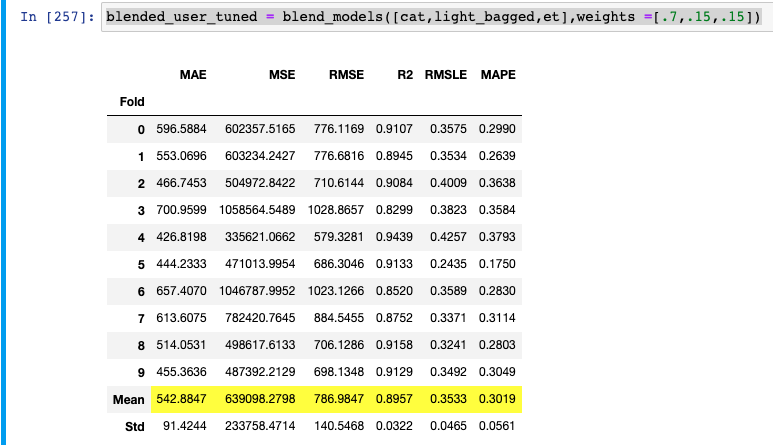

In [29]:
image = Image.open("images/overfittingcheck.png")
image

The above image shows that mean evaluation metrics for the user model after it was trained on the training set and then evaluated on the test set. In comparison to the finalized model evaluation metrics, we can confirm that the finalized model is not overfit significantly as the performance on the test set nearly matches the performance on the holdout (unseen) set.